In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
import os
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn import decomposition

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import activations
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorboard import notebook

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import sklearn
import scipy.io
import numpy
import cv2

from sklearn.svm import SVC,NuSVC
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_curve,auc
def eval_model(model):
    #predict Test Accuracy
    test_scores = model.evaluate(test,test_y,verbose=2)
    print("Testing Loss: "+str(test_scores[0]))
    print("Testing Accuracy: "+str(test_scores[1]))

    #display the ROC Curve
    classes = numpy.unique(train_y)
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1,1,1)
    for i in range(10):
        fpr,tpr,_=roc_curve(test_y,pred[:,i],pos_label=classes[i])
        auc_score = auc(fpr,tpr)
        ax.plot(fpr,tpr,label='%s: %0.2f' % (classes[i],auc_score))
    ax.legend()

    #confusion matrix
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_subplot(1,1,1)
    pred = model.predict(test)
    indexes = tf.argmax(pred,axis=1)
    cm = confusion_matrix(test_y,indexes)
    c = ConfusionMatrixDisplay(cm,display_labels=range(10))
    c.plot(ax=ax)
    ax.set_title('Testing Performance')
    eval_model(new_model)


In [18]:
root_dir = os.path.abspath(os.getcwd())+"/256_ObjectCategories/"
#add the arrays that we can use for training and testing
main_x = []
main_y = []
prev_file = [""]
current_index = 0
for subdir, dirs, files in os.walk(root_dir):
    for dir in dirs:
        current_dir = os.path.join(root_dir) + dir
        after = str(current_dir.split(".",1)[1])
        for file in os.listdir(current_dir):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                current_file = cv2.imread(os.path.join(current_dir,filename),0)
                current_file = cv2.resize(current_file, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)
                main_x.append(current_file.flatten())
                main_y.append(current_index)
                continue
            else:
                continue
        current_index = current_index+1
    break
images_x = np.array(main_x)
images_y = np.array(main_y)
print(np.shape(images_x))

(30607, 7560)


In [12]:
temp_x_train, x_test, temp_y_train, y_test = train_test_split(images_x,images_y,test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(temp_x_train,temp_y_train,test_size=0.2,random_state=42)
print(numpy.shape(x_train))
print(numpy.shape(x_test))
print(numpy.shape(x_val))

(19588, 140, 54)
(6122, 140, 54)
(4897, 140, 54)


int32


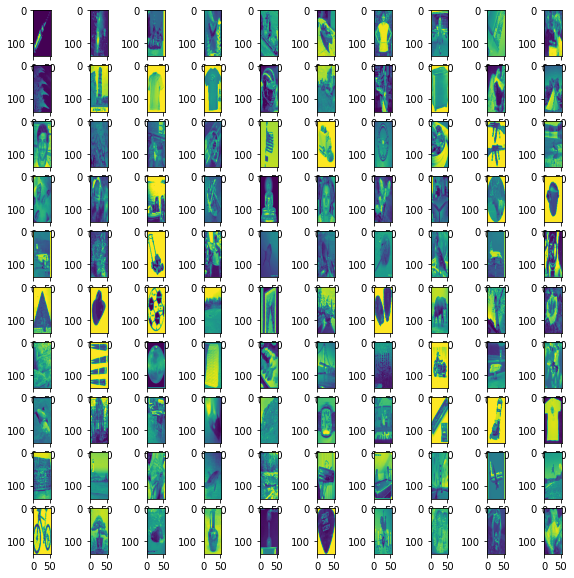

In [13]:
print(images_y.dtype)
fig = plt.figure(figsize=[10,10])
for i in range(100):
    ax = fig.add_subplot(10,10,i+1)
    ax.imshow(x_train[i,:,:])

In [16]:
#THIS DATA IS ONLY FOR THE CNN, IT WONT WORK FOR KNN OR SVM
root_dir = os.path.abspath(os.getcwd())+"/256_ObjectCategories/"
#add the arrays that we can use for training and testing
main_x = []
main_y = []
prev_file = [""]
current_index = 0
for subdir, dirs, files in os.walk(root_dir):
    for dir in dirs:
        current_dir = os.path.join(root_dir) + dir
        after = str(current_dir.split(".",1)[1])
        for file in os.listdir(current_dir):
            filename = os.fsdecode(file)
            if filename.endswith(".jpg"):
                current_file = cv2.imread(os.path.join(current_dir,filename),0)
                current_file = cv2.resize(current_file, dsize=(54, 140), interpolation=cv2.INTER_CUBIC)
                main_x.append(current_file)
                main_y.append(current_index)
                continue
            else:
                continue
        current_index = current_index+1
    break
images_x = np.array(main_x)
images_y = np.array(main_y)
print(np.shape(images_x))

(30607, 140, 54)


In [24]:
#apply PCA and dimension reduction to the data
pca = decomposition.PCA()
pca.fit(images_x)
transformed = pca.transform(images_x)
reduced_1 = numpy.reshape(transformed[:,0],(-1,1))
reconstructed = reduced_1.dot(numpy.reshape(pca.components_[0,:],(-1,1)).transpose()) + pca.mean_

In [ ]:
print(images_y.shape)

In [25]:
temp_x_train, x_test, temp_y_train, y_test = train_test_split(reconstructed,images_y,test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(temp_x_train,temp_y_train,test_size=0.2,random_state=42)
print(numpy.shape(x_train))
print(numpy.shape(x_test))
print(numpy.shape(x_val))
print(images_y[0])
print(images_y[99])

(19588, 7560)
(6122, 7560)
(4897, 7560)
0
1


In [ ]:
print(y_train[0])
print(y_train[98])

In [4]:
#setup the SVM
#grid search cross validation has already been imported ready for hyperparameter tuning
svm = SVC(class_weight='balanced')
#add some stuff for some shitty hyperparameter tuning here. You guys figure out the smarter way to do it. I belive the smarter way is using the range functionality to narrow down the range of values but you will need to investigate
#param_grid = [
#    {'C':[0.1,1,10,100],'kernel':['linear']},
#    {'C':[0.1,1,10,100],'gamma':[0.1,0.01,0.001],'kernel':['rbf']},
#    {'C':[0.1,1,10,100],'degree':[3,4,5],'kernel':['poly']},
#]
#grid_search = GridSearchCV(svm, param_grid)
#grid_search.fit(x_train,y_train)
#grid_search.cv_results_
#best_system = np.argmin(grid_search.cv_results_['rank_test_score'])
#params = grid_search.cv_results_['params'][best_system]
#print(params)
#svm = SVC().set_params(**params)
svm.fit(x_train,y_train)

SVC(class_weight='balanced')

In [9]:
#build a DCNN real quick
num_epochs = 50

def build_model(num_classes,output_activation=None):
    inputs = keras.Input(shape=(140,54,1),name='img')

    x = layers.Conv2D(filters=8, kernel_size=(3,3),padding='same',activation='relu')(inputs)
    x = layers.Conv2D(filters=8,kernel_size=(3,3),padding='same',activation=None)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SpatialDropout2D(0.2)(x)

    x = layers.MaxPool2D(pool_size=(2,2))(x)

    x = layers.Conv2D(filters=8, kernel_size=(3,3),padding='same',activation='relu')(x)
    x = layers.Conv2D(filters=8,kernel_size=(3,3),padding='same',activation=None)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SpatialDropout2D(0.2)(x)

    x = layers.MaxPool2D(pool_size=(2,2))(x)

    x = layers.Conv2D(filters=8, kernel_size=(3,3),padding='same',activation='relu')(x)
    x = layers.Conv2D(filters=8,kernel_size=(3,3),padding='same',activation=None)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.SpatialDropout2D(0.2)(x)

    x = layers.Flatten()(x)

    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64,activation='relu')(x)
    outputs = layers.Dense(num_classes,activation=output_activation)(x)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='CNN')

    return model_cnn

model_cnn = build_model(257)
model_cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 140, 54, 1)]      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 140, 54, 8)        80        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 140, 54, 8)        584       
_________________________________________________________________
batch_normalization_3 (Batch (None, 140, 54, 8)        32        
_________________________________________________________________
activation_3 (Activation)    (None, 140, 54, 8)        0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 140, 54, 8)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 70, 27, 8)         0       

In [10]:
model_cnn.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
optimizer=keras.optimizers.Adam(),
metrics=['accuracy'])
history = model_cnn.fit(x_train,y_train,
batch_size=256,
epochs=num_epochs,
validation_data=(x_test,y_test))

Epoch 1/50
97/97 [==============================] - 218s 2s/step - loss: 12.7732 - accuracy: 0.0095 - val_loss: 13.6953 - val_accuracy: 0.0265
Epoch 2/50
97/97 [==============================] - 200s 2s/step - loss: 13.7586 - accuracy: 0.0221 - val_loss: 13.4132 - val_accuracy: 0.0199
Epoch 3/50
97/97 [==============================] - 217s 2s/step - loss: 13.7847 - accuracy: 0.0154 - val_loss: 13.8386 - val_accuracy: 0.0212
Epoch 4/50
97/97 [==============================] - 198s 2s/step - loss: 14.0584 - accuracy: 0.0155 - val_loss: 13.8053 - val_accuracy: 0.0222
Epoch 5/50
97/97 [==============================] - 232s 2s/step - loss: 14.2489 - accuracy: 0.0287 - val_loss: 16.2949 - val_accuracy: 0.0114
Epoch 6/50
97/97 [==============================] - 232s 2s/step - loss: 12.0226 - accuracy: 0.0072 - val_loss: 5.5491 - val_accuracy: 0.0049
Epoch 7/50
97/97 [==============================] - 218s 2s/step - loss: 5.5503 - accuracy: 0.0034 - val_loss: 5.5491 - val_accuracy: 0.0042
Ep

KeyboardInterrupt: 